In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import databricks.koalas as ks
import seaborn as sns

In [0]:
#Leemos la BBDD importada de GIT
tennis_raw = sqlContext.sql("SELECT * FROM tennis_raw")

In [0]:
# Tomamos los datos de los partidos desde 2010

tennis_raw = tennis_raw.where(tennis_raw["tourney_date"] > "2010-01-01T00:00:00.000+0000")

In [0]:
# Convertimos a dataframe de "Koalas"

tennis_raw_ks = tennis_raw.to_koalas()

In [0]:
# Creamos un campo con id único con la concateniación del número de match y el id del torneo

tennis_raw_ks["match_num"] = tennis_raw_ks["match_num"].astype(str)
tennis_raw_ks["id_partido"] = tennis_raw_ks["tourney_id"]+tennis_raw_ks["match_num"]
tennis_raw_ks.set_index("id_partido", inplace=True)

In [0]:
# Reordenamos columnas

tennis_raw_ks = tennis_raw_ks.reindex(["winner_id","winner_seed","winner_entry","winner_name","winner_hand","winner_ht","winner_ioc",	"winner_age","w_ace","w_df","w_svpt","w_1stIn","w_1stWon","w_2ndWon","w_SvGms","w_bpSaved","w_bpFaced",'winner_rank','winner_rank_points',"score","best_of","round","minutes","surface","draw_size","tourney_level","tourney_date","match_num","tourney_id","tourney_name","loser_id","loser_seed","loser_entry","loser_name","loser_hand","loser_ht","loser_ioc","loser_age",'l_ace',"l_df","l_svpt","l_1stIn","l_1stWon","l_2ndWon","l_SvGms","l_bpSaved",'l_bpFaced','loser_rank','loser_rank_points'], axis=1)

In [0]:
# Creamos un df solamente con los winners y asignamos variable binario winner == 1
tennis_winers = tennis_raw_ks.iloc[:,0:30]
tennis_winers["winner"] = 1

In [0]:
# Renombramos columnas

tennis_winers.rename(columns={"winner_id":"player_id","winner_seed":"seed","winner_entry":"entry","winner_name":"player_name","winner_hand":"player_hand","winner_ht":"player_ht","winner_ioc":"player_ioc",	"winner_age":"player_age","w_ace":"ace","w_df":"df","w_svpt":'svpt',"w_1stIn":"1stIn","w_1stWon":"1stWon","w_2ndWon":"2ndWon","w_SvGms":"SvGms","w_bpSaved":"bpSaved","w_bpFaced":"bpFaced",'winner_rank':"player_rank","winner_rank_points":"player_rank_points"}, inplace=True)

In [0]:
# Creamos un df solamente con los loosers y asignamos variable binario winner == 0

tennis_loosers = tennis_raw_ks.iloc[:,19:49]
tennis_loosers["winner"] = 0

In [0]:
# Renombramos columnas

tennis_loosers.rename(columns={"loser_id":"player_id","loser_seed":"seed","loser_entry":"entry","loser_name":"player_name","loser_hand":"player_hand","loser_ht":"player_ht","loser_ioc":"player_ioc","loser_age":"player_age",'l_ace':"ace","l_df":"df","l_svpt":'svpt',"l_1stIn":"1stIn","l_1stWon":"1stWon","l_2ndWon":"2ndWon","l_SvGms":"SvGms","l_bpSaved":"bpSaved",'l_bpFaced':"bpFaced",'loser_rank':"player_rank","loser_rank_points":"player_rank_points"}, inplace=True)

In [0]:
# Unimos ambos dfs para crear uno df total

total_df = ks.concat([tennis_winers,tennis_loosers], axis=0)

In [0]:
# Seleccionamos las columnas que usaremos

regresion_df = total_df[["seed","player_hand","player_ht","player_age","player_name","df","tourney_name","1stIn","1stWon","2ndWon","SvGms","bpSaved","bpFaced","player_rank","player_rank_points","best_of","round","surface","tourney_level","winner","draw_size","ace","svpt"]]

In [0]:
# Creamos una variable que contendrá la media de aces por jugador, superficie, edad, nivel de torneo, ganador y draw size

mean_svpt_df = ks.DataFrame(regresion_df.groupby(["player_name","surface","player_age","tourney_level","draw_size","winner"])["svpt"].mean()).rename(columns={"svpt":"svpt_mean"})
mean_svpt_df.reset_index(inplace=True)
mean_svpt_df = mean_svpt_df[["player_name","surface","player_age","tourney_level","draw_size","winner","svpt_mean"]]
regresion_df = ks.merge(regresion_df,mean_svpt_df, on = ["player_name","surface","player_age","tourney_level","draw_size","winner"])


In [0]:
# Nos dehacemos de los registros que tienen valores nulos o 0

regresion_df = regresion_df.dropna(subset=["player_ht","player_age","ace","player_rank_points","player_rank","surface","player_hand","tourney_level","draw_size","seed"])

In [0]:
# Vectorizamos variables categóricas

surface = ks.get_dummies(regresion_df["surface"])
regresion_df = ks.concat([regresion_df, surface], axis=1)

hand = ks.get_dummies(regresion_df["player_hand"])
regresion_df = ks.concat([regresion_df, hand], axis=1)

level_tourney = ks.get_dummies(regresion_df["tourney_level"])
regresion_df = ks.concat([regresion_df, level_tourney], axis=1)

draw_size = ks.get_dummies(regresion_df["draw_size"])
regresion_df = ks.concat([regresion_df, draw_size], axis=1)


In [0]:
display(regresion_df)

seed,player_hand,player_ht,player_age,player_name,df,tourney_name,1stIn,1stWon,2ndWon,SvGms,bpSaved,bpFaced,player_rank,player_rank_points,best_of,round,surface,tourney_level,winner,draw_size,ace,svpt,svpt_mean,Carpet,Clay,Grass,Hard,L,R,U,A,D,F,G,M,4,8,16,28,32,48,56,64,96,128
5.0,R,188.0,27.112936345,Jo-Wilfried Tsonga,2.0,Roland Garros,105.0,71.0,30.0,25.0,11.0,17.0,5.0,4965.0,5,R16,Clay,G,1,128,4.0,164.0,113.5,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
5.0,R,188.0,27.112936345,Jo-Wilfried Tsonga,1.0,Roland Garros,60.0,43.0,12.0,16.0,3.0,8.0,5.0,4965.0,5,R32,Clay,G,1,128,7.0,93.0,113.5,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
5.0,R,188.0,27.112936345,Jo-Wilfried Tsonga,3.0,Roland Garros,58.0,40.0,24.0,16.0,4.0,7.0,5.0,4965.0,5,R64,Clay,G,1,128,4.0,97.0,113.5,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
5.0,R,188.0,27.112936345,Jo-Wilfried Tsonga,1.0,Roland Garros,63.0,48.0,22.0,17.0,4.0,6.0,5.0,4965.0,5,R128,Clay,G,1,128,10.0,100.0,113.5,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
null,R,190.0,30.1108829569,Lukasz Kubot,3.0,Wimbledon,65.0,46.0,15.0,15.0,2.0,5.0,49.0,855.0,5,R128,Grass,G,1,128,9.0,92.0,92.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
null,R,185.0,24.643394935,Lukas Lacko,1.0,Wimbledon,93.0,78.0,26.0,25.0,5.0,8.0,60.0,763.0,5,R64,Grass,G,1,128,25.0,148.0,120.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
null,R,185.0,24.643394935,Lukas Lacko,1.0,Wimbledon,60.0,50.0,17.0,14.0,1.0,2.0,60.0,763.0,5,R128,Grass,G,1,128,9.0,92.0,120.0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
null,R,null,25.8699520876,Bruno Rodriguez,null,Davis Cup G2 R3: DOM vs MEX,null,null,null,null,null,null,914.0,12.0,3,RR,Clay,D,1,4,null,null,null,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
null,R,183.0,27.055441478400002,Nicolas Almagro,null,Davis Cup WG SF: ESP vs USA,null,null,null,null,null,null,12.0,2475.0,5,RR,Clay,D,1,4,null,null,null,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
null,R,175.0,30.614647501700002,David Ferrer,null,Davis Cup WG F: ESP vs CZE,null,null,null,null,null,null,5.0,6430.0,3,RR,Hard,D,1,4,null,null,null,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [0]:
# Reordenamos columnas

regresion_df = regresion_df.reindex(['player_ht','player_age','player_name','player_rank','player_rank_points','winner','Carpet','Clay','Grass','Hard','L','R','U','A','D','F','G','M',4,8,28,32,48,56,64,96,128,'svpt_mean','svpt'],axis = 1)

In [0]:
display(regresion_df)

player_ht,player_age,player_name,player_rank,player_rank_points,winner,Carpet,Clay,Grass,Hard,L,R,U,A,D,F,G,M,4,8,28,32,48,56,64,96,128,svpt_mean,svpt
188.0,27.112936345,Jo-Wilfried Tsonga,5.0,4965.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,113.5,164.0
188.0,27.112936345,Jo-Wilfried Tsonga,5.0,4965.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,113.5,93.0
188.0,27.112936345,Jo-Wilfried Tsonga,5.0,4965.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,113.5,97.0
188.0,27.112936345,Jo-Wilfried Tsonga,5.0,4965.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,113.5,100.0
190.0,30.1108829569,Lukasz Kubot,49.0,855.0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,92.0,92.0
185.0,24.643394935,Lukas Lacko,60.0,763.0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,120.0,148.0
185.0,24.643394935,Lukas Lacko,60.0,763.0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,120.0,92.0
178.0,29.2484599589,Philipp Kohlschreiber,19.0,1830.0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,82.0,88.0
178.0,29.2484599589,Philipp Kohlschreiber,19.0,1830.0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,82.0,76.0
183.0,27.630390143699998,Nicolas Almagro,12.0,2390.0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,58.333333333333336,45.0


In [0]:
regresion_df["svpt_mean"] = regresion_df["svpt_mean"].astype("float").round(2)

In [0]:
"""Vemos un resumen del modo en que están distribuidos los datos"""

regresion_df.describe()

Out[41]:

,player_ht,player_age,player_rank,player_rank_points,winner,Carpet,Clay,Grass,Hard,L,R,U,A,D,F,G,M,4,8,28,32,48,56,64,96,128,svpt_mean,svpt
count,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.0,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000,45802.000000
mean,186.457840,28.182601,62.726366,1683.741278,0.517117,0.000175,0.306733,0.119798,0.573294,0.135343,0.864657,0.0,0.570084,0.012052,0.006222,0.192830,0.218811,0.012052,0.005567,0.188463,0.302520,0.050958,0.100541,0.074451,0.047902,0.216890,79.664260,79.664272
std,7.332364,3.657212,78.315247,2113.801478,0.499712,0.013215,0.461143,0.324729,0.494604,0.342094,0.342094,0.0,0.495069,0.109119,0.078637,0.394525,0.413445,0.109119,0.074408,0.391086,0.459354,0.219915,0.300724,0.262506,0.213561,0.412132,26.952317,29.493658
min,163.000000,16.235455,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,183.000000,25.579740,21.000000,650.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,61.000000,58.000000
50%,185.000000,28.202601,46.000000,955.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.000000,75.000000
75%,190.000000,30.688569,80.000000,1700.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,93.500000,96.000000
max,208.000000,44.060233,1890.000000,16950.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,491.000000,491.000000


In [0]:
# Eliminamos los registros que tienen un valor de "SVPT" superior a 150 por considerarse outliers

regresion_df = regresion_df[regresion_df["svpt"]<150]

In [0]:
display(regresion_df)

player_ht,player_age,player_name,player_rank,player_rank_points,winner,Carpet,Clay,Grass,Hard,L,R,U,A,D,F,G,M,4,8,28,32,48,56,64,96,128,aces_mean,ace
180.0,26.160164271,Alexandr Dolgopolov,23.0,1455.0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,6.0,6.0
193.0,24.709103353899998,Vasek Pospisil,62.0,785.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,9.0,9.0
198.0,33.6317590691,Victor Hanescu,146.0,375.0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,10.0,10.0
190.0,28.079397672800003,Andreas Haider Maurer,47.0,946.0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,6.0,6.0
183.0,30.157426420300002,Stan Wawrinka,9.0,3845.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,8.86,9.0
183.0,30.157426420300002,Stan Wawrinka,9.0,3845.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,8.86,15.0
183.0,30.157426420300002,Stan Wawrinka,9.0,3845.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,8.86,4.0
183.0,30.157426420300002,Stan Wawrinka,9.0,3845.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,8.86,5.0
183.0,30.157426420300002,Stan Wawrinka,9.0,3845.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,8.86,8.0
183.0,30.157426420300002,Stan Wawrinka,9.0,3845.0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,8.86,11.0


##MODELO DE REGRESIÓN

In [0]:
regresion_df_pandas = regresion_df.toPandas()

/databricks/python/lib/python3.7/site-packages/databricks/koalas/frame.py:4275: FutureWarning: DataFrame.toPandas is deprecated as of DataFrame.to_pandas. Please use the API instead.
 FutureWarning,

In [0]:
regresion_df_final = regresion_df_pandas[['player_ht','player_age','Carpet','Clay','Grass','Hard','A','D','F','G','M',4,8,28,32,48,56,64,96,128,'svpt_mean','svpt']]

Out[24]:

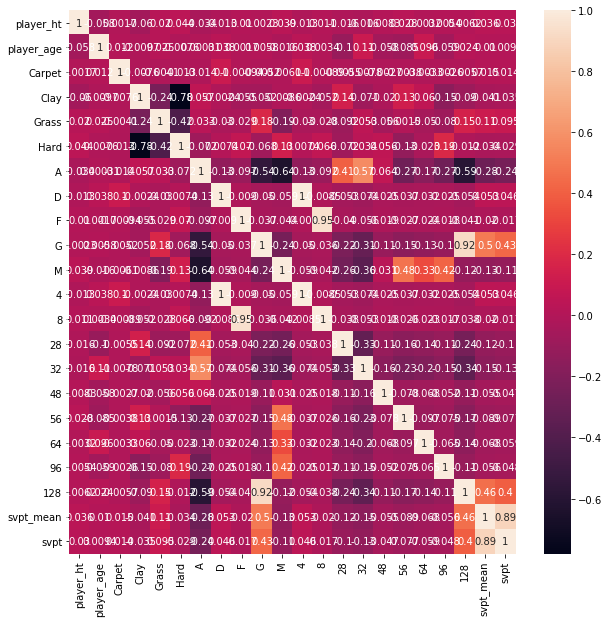

<matplotlib.axes._subplots.AxesSubplot at 0x7fed9a5b9e90>

In [0]:
#calculamos la matriz de correlación y la mostramos graficamente

matriz_corr = regresion_df_final.corr()
plt.figure(figsize=(10,10))
sns.heatmap(matriz_corr,xticklabels=matriz_corr.columns,yticklabels=matriz_corr.columns,annot=True)

In [0]:
regresion_df_final

Out[46]:

,player_ht,player_age,Carpet,Clay,Grass,Hard,A,D,F,G,M,4,8,28,32,48,56,64,96,128,svpt_mean,svpt
1,188.0,27.112936,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,113.5,93.0
2,188.0,27.112936,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,113.5,97.0
3,188.0,27.112936,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,113.5,100.0
4,190.0,30.110883,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,92.0,92.0
5,185.0,24.643395,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,120.0,148.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58261,168.0,30.762491,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,54.0,54.0
58262,183.0,23.509925,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,60.0,60.0
58263,198.0,24.257358,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,61.0,61.0
58264,196.0,24.509240,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,147.0,147.0


In [0]:
#Seleccionamos las variables dependientes e independientes
x_features = regresion_df_final.iloc[:,0:21]
y_target = regresion_df_final.iloc[:,21]

In [0]:
x_features

Out[48]:

,player_ht,player_age,Carpet,Clay,Grass,Hard,A,D,F,G,M,4,8,28,32,48,56,64,96,128,svpt_mean
1,188.0,27.112936,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,113.5
2,188.0,27.112936,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,113.5
3,188.0,27.112936,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,113.5
4,190.0,30.110883,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,92.0
5,185.0,24.643395,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,120.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58261,168.0,30.762491,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,54.0
58262,183.0,23.509925,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,60.0
58263,198.0,24.257358,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,61.0
58264,196.0,24.509240,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,147.0


In [0]:
y_target

Out[49]: 1 93.0
2 97.0
3 100.0
4 92.0
5 148.0
 ... 
58261 54.0
58262 60.0
58263 61.0
58264 147.0
58265 89.0
Name: svpt, Length: 44469, dtype: float64

In [0]:
# Dividimos en train y test
X_train, X_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.2)

In [0]:
# Aplicamos la regresión a los datos

lr_multiple = linear_model.LinearRegression()

lr_multiple.fit(X_train, y_train)

Out[51]: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Realizamos las predicciones para Y

Y_pred_multiple = lr_multiple.predict(X_test)

In [0]:
# Valores de los coeficientes y término independiente

print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print()
print('Valor de los coeficientes:')
print(lr_multiple.coef_)
print('Valor del término independiente:')
print(lr_multiple.intercept_)

DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE

Valor de los coeficientes:
[-1.03890010e-02 3.27262011e-03 4.94090801e+00 -1.55702175e+00
 -1.76113321e+00 -1.62275305e+00 1.06409417e-01 -3.18620757e-01
 1.01974305e+00 -9.98194003e-01 1.90662291e-01 -3.18620757e-01
 -9.33999551e-01 2.57893844e-02 5.29648022e-02 -5.73985240e-02
 -1.26845613e-01 -1.10390691e-01 -8.12210286e-02 -4.04020625e-01
 9.82079234e-01]
Valor del término independiente:
4.667627385964835

In [0]:
#Precisión del modelo

print('Precisión del modelo:')
print(lr_multiple.score(X_train, y_train)*100,"%")

Precisión del modelo:
79.74424527712367 %